In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from scipy.optimize import leastsq
from scipy.stats import norm                                                                                                                                                                                                                                                                                                                                                                                                                   
from scipy.optimize import curve_fit
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


# 4 Kinematical signature
Aug 30, 2017

In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mupClassification/Figures/KinematicalSignature/'

# pairs of tracks at close proximity

In [3]:
versions['overlay date'] = '2018_05_11'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
OverlayPairsFV,OverlaySamples = load_MCbnbDATAcosmicSamples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')
print "%d"%len(OverlaySamples['cosmic'])+' cosmic pairs and %d'%len(OverlaySamples['1mu-1p'])+' mu-p pairs in overlay'

283762 pairs from MC-BNB + cosmic DATA overlay
186485 pairs in FV
49707 are 1mu-1p, 26.7%
41519 are other pairs, 22.3%
95259 are cosmic, 51.1%
--------------------------------------------------------------
23996 are CC 1p 0pi, 12.9%
95259 cosmic pairs and 49707 mu-p pairs in overlay


In [4]:
cuts_order  = ['no cut'
               ,'Chi2Proton'               
               ,'MatchedFlash'               
               ,'length'
               ,'non-collinearity'               
               ,'vertex activity'               
               ,'delta phi'               
               ,'Pt no delta phi'               
               ,'Pt & delta phi'
              ]


cutlabels = ['preselection'
             ,'$dE/dx$ profile'
             ,'optical filter'
             ,'track lengths'
             ,'collinearity'
             ,'vertex activity'
             ,'coplanarity'
             ,'$p_t$ imbalance'
             ,r'$\Delta \phi $ \&  $p_{t}$'
            ]

reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples
                                                                   ,cuts_order=cuts_order)
pureffOverlay

$\mu p$ eff. $\mu p$ pur. CC$0\pi 1 p$ eff.  \
no cut                 100.0%        26.7%            100.0%   
Chi2Proton              63.1%        70.7%             68.7%   
MatchedFlash            51.6%        78.1%             56.3%   
length                  47.2%        83.5%             52.5%   
non-collinearity        43.1%        87.4%             49.7%   
vertex activity         31.0%        89.1%             44.2%   
delta phi               20.6%        95.3%             33.7%   
Pt no delta phi         23.3%        92.4%             36.0%   
Pt & delta phi          18.2%        96.3%             30.4%   

                 CC$0\pi 1 p$ pur.             label          1mu-1p  \
no cut                       12.9%            no cut  100.0% (49707)   
Chi2Proton                   37.1%        Chi2Proton   63.1% (31389)   
MatchedFlash                 41.2%      MatchedFlash   51.6% (25634)   
length                       44.8%            length   47.2% (23459)   
non-collinearity             48.7%  non-collinearity   43.1% (21412)   
vertex activity              61.5%   vertex activity   31.0% (15391)   
delta phi                    75.2%         delta phi   20.6% (10241)   
Pt no delta phi              69.0%   Pt no delta phi   23.3% (11582)   
Pt & delta phi               77.8%    Pt & delta phi    18.2% (9035)   

                     other pairs          cosmic       CC 1p 0pi  
no cut            100.0% (41519)  100.0% (95259)  100.0% (23996)  
Chi2Proton          19.3% (8021)     5.2% (5001)   68.7% (16481)  
MatchedFlash        13.2% (5491)     1.8% (1688)   56.3% (13510)  
length               7.9% (3281)     1.4% (1369)   52.5% (12600)  
non-collinearity     5.8% (2409)      0.7% (673)   49.7% (11926)  
vertex activity      3.7% (1538)      0.4% (346)   44.2% (10616)  
delta phi             0.9% (382)      0.1% (118)    33.7% (8080)  
Pt no delta phi       1.8% (767)      0.2% (185)    36.0% (8646)  
Pt & delta phi        0.7% (270)       0.1% (79)    30.4% (7304)

## 4.I The reconstructed momentum of the muon and the proton candidates

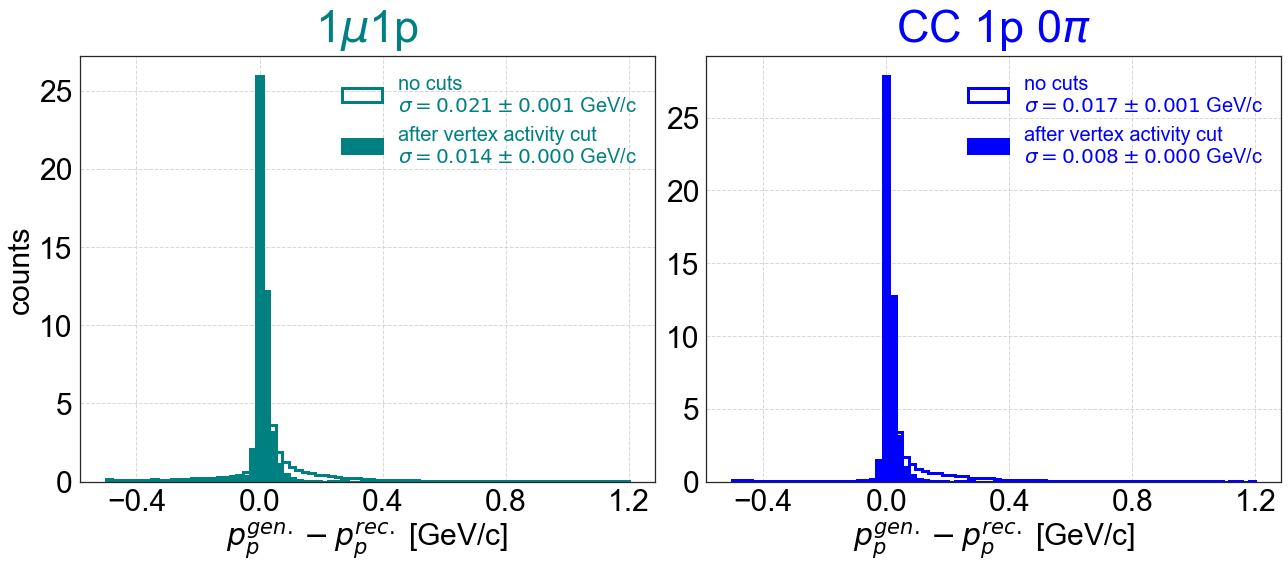

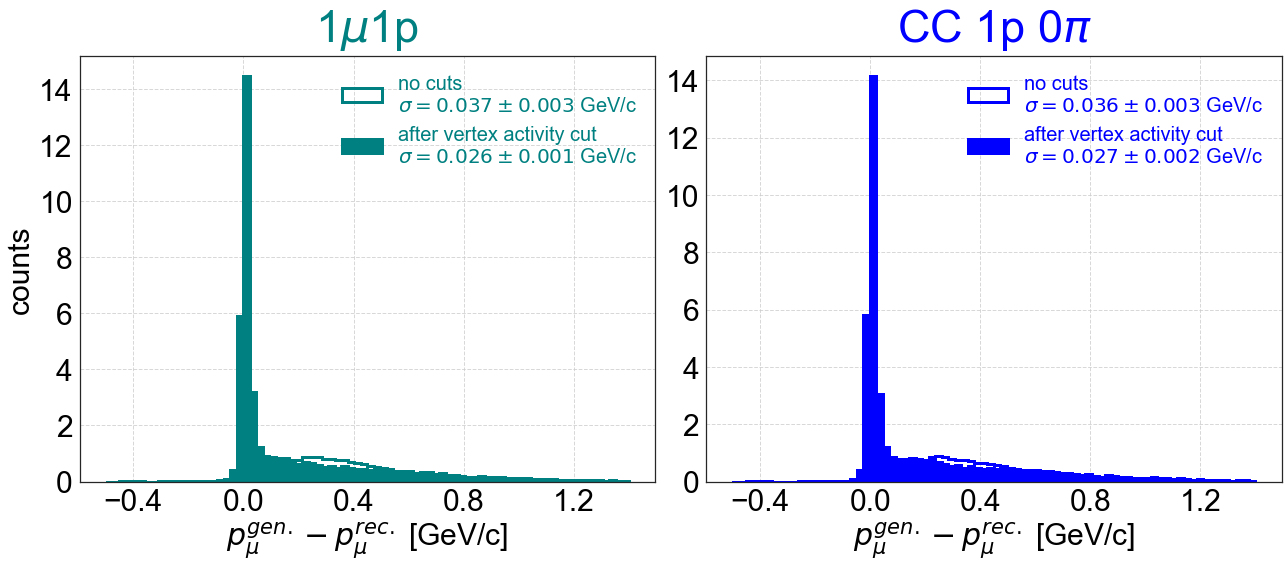

In [19]:
for particle,p_name,xmax in zip(['p','mu'],['p','\\mu'],[1.2,1.4]):
    bins=linspace(-0.5,xmax,81)
    fig=plt.figure(figsize=(18,8))
    for i,index in enumerate([0,3]):
        pair_type,label,cmap,color = get_pair_hpars(index)
        ax = fig.add_subplot(1,2,i+1)
        ax.set_title(label,fontsize=45,y=1.02,color=color)
        for cut_name,label in zip(['no cut','vertex activity']
                                  ,['no cuts','after vertex activity cut']):
            sample = reducedOverlay[cut_name][pair_type]                    
            delta = (sample['truth_P'+particle] - sample['reco_P'+particle])
            truncated = sample[np.abs(sample['truth_P'+particle] - sample['reco_P'+particle])<2]
            delta_truncated = (sample['truth_P'+particle] - sample['reco_P'+particle])
            h_truncated,bins = np.histogram( delta_truncated , bins=bins,normed=1);
            mid = 0.5*(bins[1:]+bins[:-1])    
            xdata = mid
            ydata = h_truncated
            pars, cov = curve_fit(lambda x, mu, sig : norm.pdf(x, loc=mu, scale=sig), xdata, ydata, p0=[0,9])  
            mu,sigma = pars
            mu_err,sigma_err = np.sqrt(cov[0,0]),np.sqrt(cov[1,1])
            h,bins,_=ax.hist(delta,bins=bins,normed=1
                             ,histtype='step' if cut_name=='no cut' else 'stepfilled'
                             ,color=color
                             ,edgecolor=color
                             ,linewidth=3
                             ,label=label + '\n' + r'$\sigma=%.3f \pm %.3f$'%( pars[1], np.sqrt(cov[1,1 ]))+' GeV/c');
        set_axes(ax,'$p_{'+p_name+'}^{gen.}-p_{'+p_name+'}^{rec.}$ [GeV/c]' , 'counts' if i==0 else ''
                 ,fontsize=30,do_add_grid=True
                 ,xticks=[-0.4,0,0.4,0.8,1.2]
                )
    
        leg = plt.legend(fontsize=20)
        for text in leg.get_texts():
            text.set_color(color)
    plt.tight_layout()
    fig.savefig(figures_path+'recoMomenta/P'+particle+'_gen_reco.pdf')

### 4.II Coplanarity - ∆φ between tracks

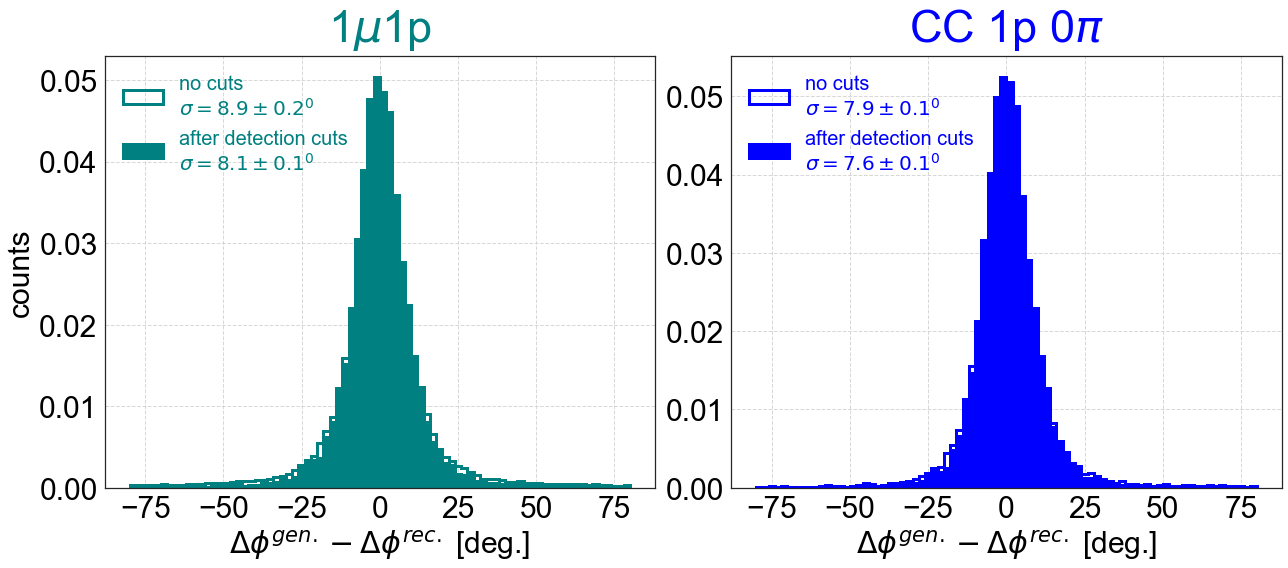

In [24]:
# MC-bnb/DATA-cosmic
fig=plt.figure(figsize=(18,8))
bins=linspace(-80,80,81)
for i,index in enumerate([0,3]):
    pair_type,label,cmap,color = get_pair_hpars(index)
    ax = fig.add_subplot(1,2,i+1)
    ax.set_title(label,fontsize=45,y=1.02,color=color)

    for cut_name,label in zip(['no cut','vertex activity']
                                  ,['no cuts','after detection cuts']):
        sample = reducedOverlay[cut_name][pair_type]                    
        delta = (sample['truth_delta_phi'] - sample['delta_phi'])
        truncated = sample[np.abs(sample['truth_delta_phi'] - sample['delta_phi'])<25]
        delta_truncated = (sample['truth_delta_phi'] - sample['delta_phi'])
        h_truncated,bins = np.histogram( delta_truncated , bins=bins,normed=1);
        mid = 0.5*(bins[1:]+bins[:-1])    
        xdata = mid
        ydata = h_truncated
        pars, cov = curve_fit(lambda x, mu, sig : norm.pdf(x, loc=mu, scale=sig), xdata, ydata, p0=[0,9])  
        mu,sigma = pars
        mu_err,sigma_err = np.sqrt(cov[0,0]),np.sqrt(cov[1,1])
        h,bins,_=ax.hist(delta,bins=bins,normed=1
                             ,histtype='step' if cut_name=='no cut' else 'stepfilled'
                             ,color=color
                             ,edgecolor=color
                             ,linewidth=3
                         ,label=label + '\n' + r'$\sigma=%.1f \pm %.1f$'%( pars[1], np.sqrt(cov[1,1 ]))+'$^0$');
        set_axes(ax,r'$\Delta \phi^{gen.}-\Delta \phi^{rec.}$ [deg.]' , 'counts' if i==0 else ''
                 ,fontsize=30,do_add_grid=True
                 ,xticks=[-75,-50,-25,0,25,50,75]
                )    
        leg = plt.legend(fontsize=20,loc='upper left')
        for text in leg.get_texts():
            text.set_color(color)
ax.grid(linestyle='--',alpha=0.75)
plt.tight_layout()
fig.savefig(figures_path+'Coplanarity/delta_phi_gen_reco.pdf')

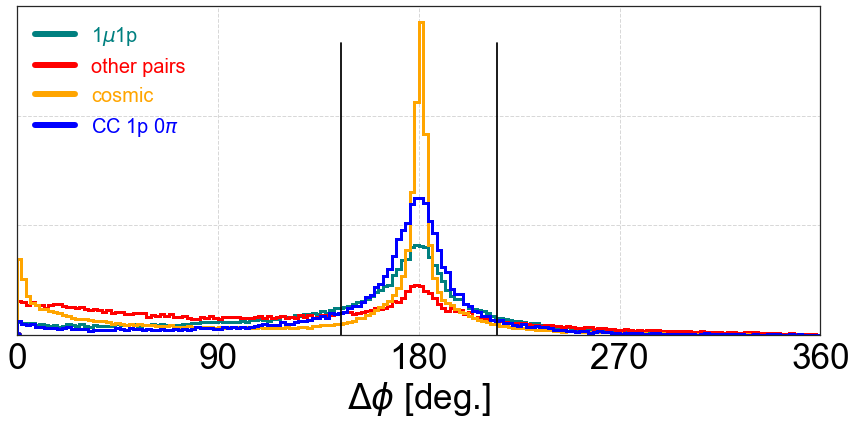

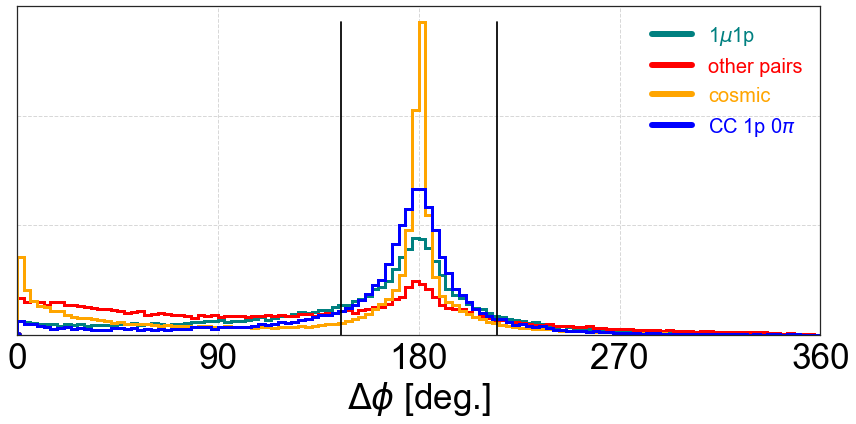

In [29]:
plot_feature_pairs(reduced_samples=reducedOverlay['no cut']
                   ,var='delta_phi',x_label=r'$\Delta \phi$ [deg.]',do_add_legend=True,legend_loc='upper left'
                              ,bins=np.linspace(0,360,181),figsize=(12,6),ticks_color='black',fontsize=35,legend_fontsize=20)
plt.plot([145,145],[0,0.05],'-',[215,215],[0,0.05],'-',color='black')
plt.savefig(figures_path+'Coplanarity/DeltaPhi.pdf')

# after cut 4
plot_feature_pairs(reduced_samples=reducedOverlay['no cut'],var='delta_phi',x_label=r'$\Delta \phi$ [deg.]',do_add_legend=True,legend_loc='upper right'
                              ,bins=np.linspace(0,360,121),figsize=(12,6),ticks_color='black',fontsize=35,legend_fontsize=20)
plt.plot([145,145],[0,0.05],'-',[215,215],[0,0.05],'-',color='black')
plt.savefig(figures_path+'Coplanarity/DeltaPhi_after_VertexActivity_cut.pdf')

In [31]:
#---------------------------------------------------------------------------------------------
# Feb-14, 2018
def plot_cut_samples (reduced_samples=None,
                      markers_size=5,
                      cut_name='maximal distance between tracks',mul=1,
                      cut_var ='distance',
                      cut_type= 'max',
                      x_label = 'maximal tracks distance [cm]', y_label='% of sample',
                      xcenter=0,figsize=(12,8),fontsize=25,
                      xmin=0.1, xmax=10 , Nbins=10, do_add_legend=True, legend_loc='bbox',legend_fontsize=25,
                      ticks_color='black'):
    leg=None
    fig,ax=plt.subplots(figsize=figsize)
    for i,(pair_type,label,cmap,color) in enumerate(zip(pair_types,MClabels,MCcmaps,MCcolors)):
        sample = reduced_samples[pair_type]
        if cut_type=='max' or cut_type=='min':
            x , frac , frac_err = get_fraction_in_cut( data=sample , cut_var=cut_var , mul=mul , cut_type=cut_type , xmin=xmin, xmax=xmax , Nbins=Nbins )
        elif cut_type=='symmetric':
            x , frac , frac_err = get_fraction_in_symmetriccut( data=sample , cut_var=cut_var , mul=mul , xcenter=xcenter, delta_x_min=xmin, delta_x_max=xmax , Nbins=Nbins )
        plt.errorbar(x , y=frac, yerr=frac_err , xerr=0, fmt='o' , markersize=markers_size , label=label, color=color)
    if do_add_legend:
        if 'bbox' not in legend_loc:
            leg=ax.legend(fontsize=legend_fontsize,loc=legend_loc,markerscale=2.)
        else:
            leg=ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.,fontsize=legend_fontsize,markerscale=2.)
        for color,text in zip(MCcolors,leg.get_texts()):
            text.set_color(color)
    ax.set_ylim(0,101)
    ax.set_xlim(xmin,xmax)
    set_axes(ax,x_label=x_label,y_label=y_label,fontsize=fontsize,ticks_color=ticks_color,xticks=np.linspace(xmin,xmax,7),yticks=[25,50,75,100])
    ax.grid(linestyle='--',alpha=0.75)
    plt.tight_layout()
    if leg is None: return ax
    return ax,leg
#---------------------------------------------------------------------------------------------

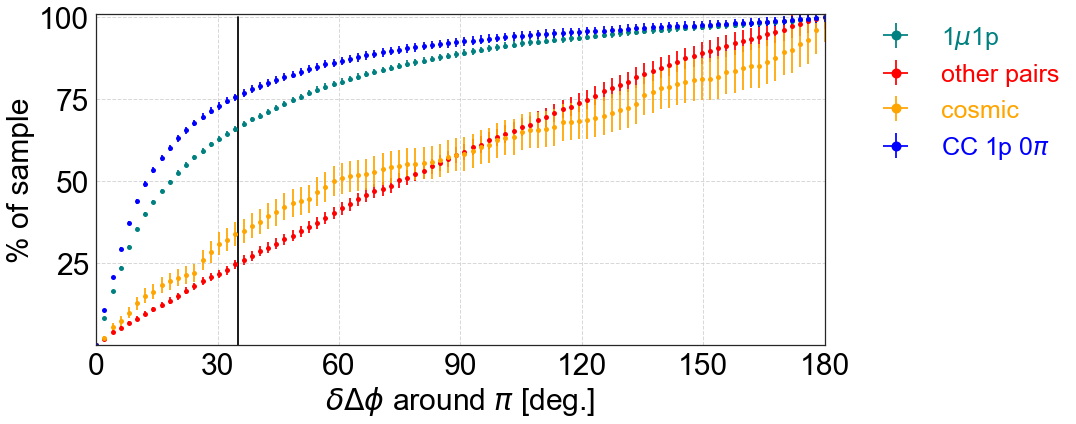

In [32]:
ax,leg=plot_cut_samples(reduced_samples=reducedOverlay['vertex activity']
                        ,do_add_legend=True,
                     cut_var ='delta_phi',cut_type= 'symmetric',x_label=r'$\delta \Delta \phi$ around $\pi$ [deg.]',ticks_color='black',
                     xcenter=180, xmin=0., xmax=180 , Nbins=90,fontsize=30,figsize=(12,6))
plt.plot([35,35],[0,100],'-',color='black')
plt.savefig(figures_path+'Coplanarity/DeltaPhi_cuts.pdf',bbox_extra_artists=(leg,), bbox_inches='tight')

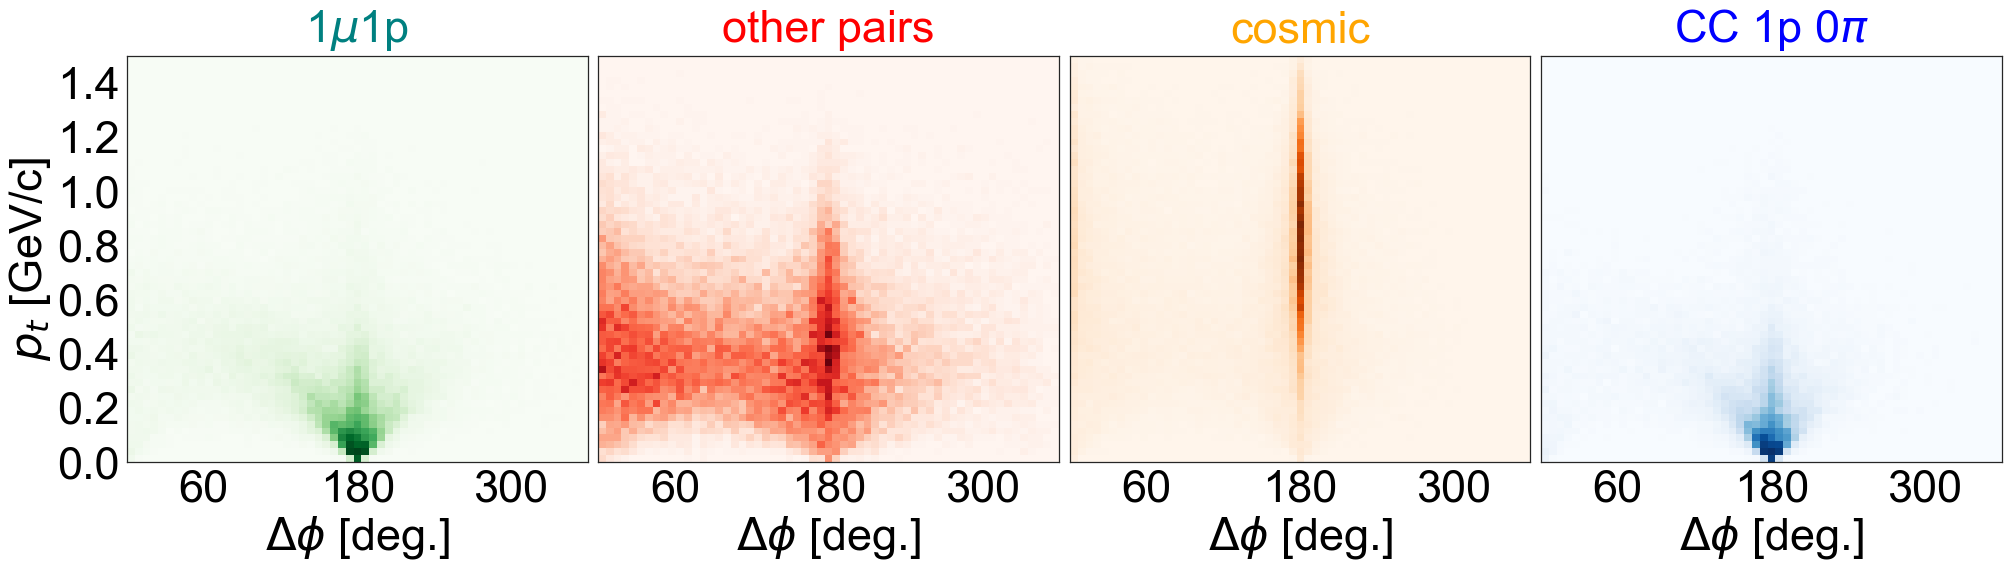

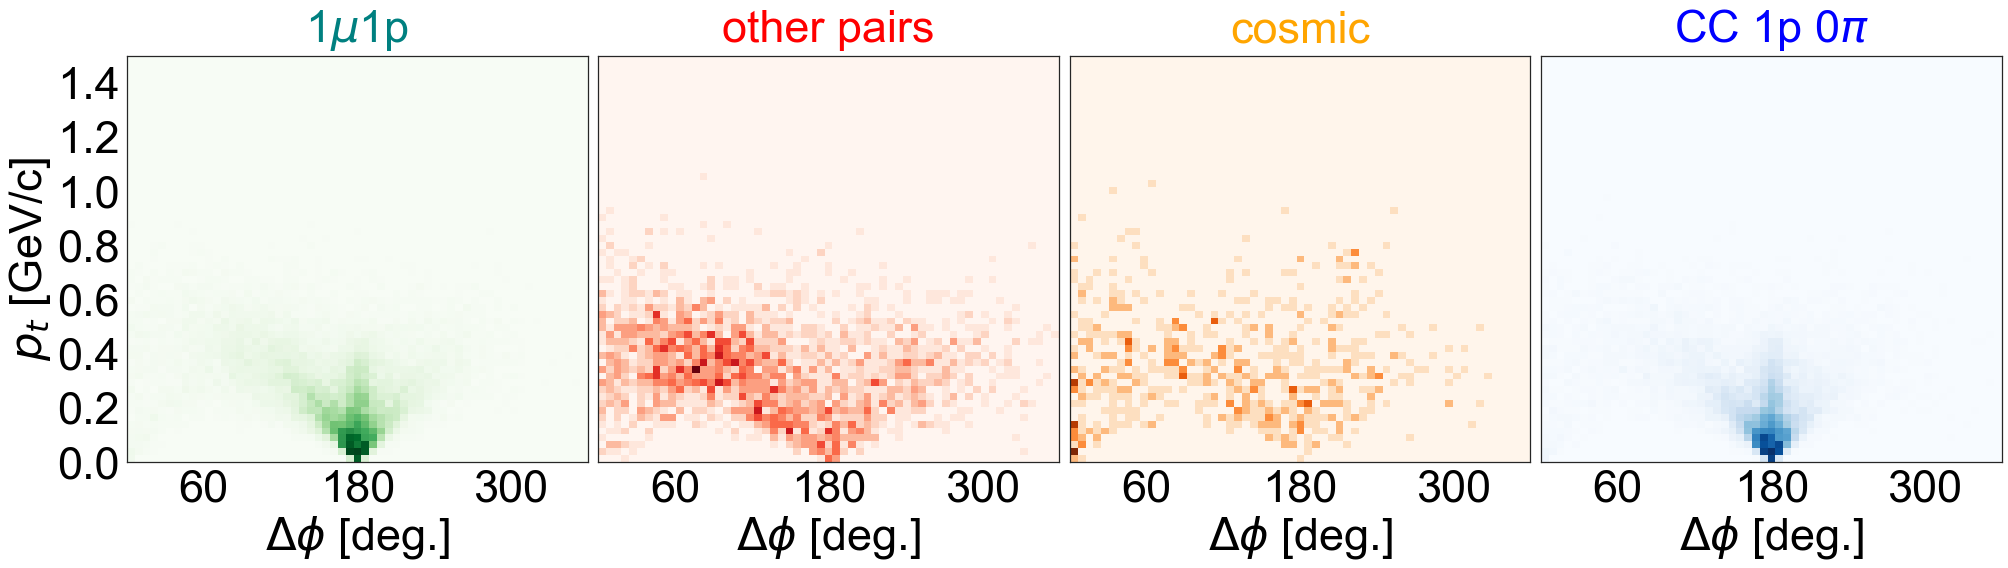

In [37]:
fig = plt.figure(figsize=(28,8))
bins=(np.linspace(0,360,60),np.linspace(0,1.5,60))
x_label,y_label='$\\Delta \\phi$ [deg.]','$p_{t}$ [GeV/c]'
for i,(pair_type,label,cmap,color) in enumerate(zip(pair_types,MClabels,MCcmaps,MCcolors)):
    sample = reducedOverlay['no cut'][pair_type]
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(label,fontsize=45,y=1.02,color=color)
    plot_2d_hist(sample['delta_phi'], 
                 sample['reco_Pt'],
                 ax=ax,fontsize=25,ticks_color='black',bins=bins,cmap=cmap,norm='')            
    set_axes(ax,x_label=x_label, y_label=y_label if i==0 else '',ticks_color='black',fontsize=45)
    ax.xaxis.set_ticks([60,180,300])
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f') if i==0 else ticker.NullFormatter())    
plt.tight_layout()
fig.savefig(figures_path+'Coplanarity/DeltaPhi_vs_Pt.pdf')


fig = plt.figure(figsize=(28,8))
for i,(pair_type,label,cmap,color) in enumerate(zip(pair_types,MClabels,MCcmaps,MCcolors)):
    sample = reducedOverlay['non-collinearity'][pair_type]
    ax = fig.add_subplot(1,4,i+1)
    ax.set_title(label,fontsize=45,y=1.02,color=color)
    plot_2d_hist(sample['delta_phi'], 
                 sample['reco_Pt'],
                 ax=ax,fontsize=25,ticks_color='black',bins=bins,cmap=cmap,norm='')            
    set_axes(ax,x_label=x_label, y_label=y_label if i==0 else '',ticks_color='black',fontsize=45)
    ax.xaxis.set_ticks([60,180,300])
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f') if i==0 else ticker.NullFormatter())    
plt.tight_layout()
fig.savefig(figures_path+'Coplanarity/DeltaPhi_vs_Pt_after_VertexActivity_cut.pdf')

## Appendix A Reconstructed $\theta (p,q)$

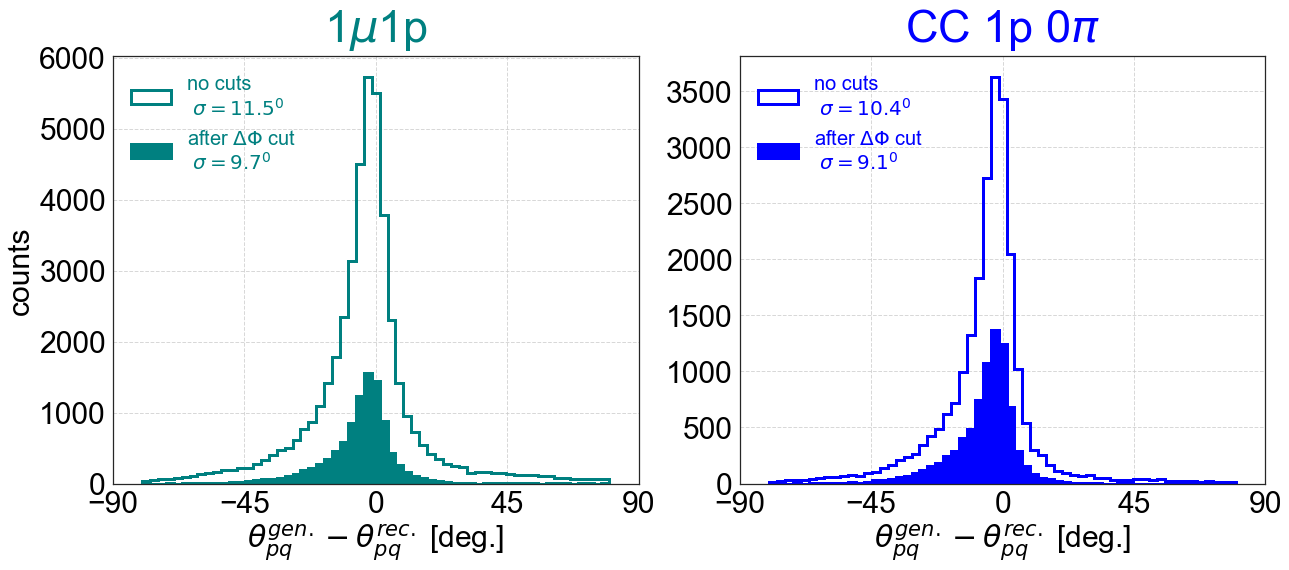

In [5]:
# MC-bnb/DATA-cosmic
fig=plt.figure(figsize=(18,8))
for i,index in enumerate([0,3]):
    pair_type,label,cmap,color = get_pair_hpars(index)
    ax = fig.add_subplot(1,2,i+1)
    ax.set_title(label,fontsize=45,y=1.02,color=color)
    for cut_name,label in zip(['no cut','delta phi']
                                  ,['no cuts',r'after $\Delta \Phi$ cut']):
        sample = reducedOverlay[cut_name][pair_type]                    
        delta = sample['truth_theta_pq']-sample['reco_theta_pq']
        small_sample = sample[np.abs(sample['truth_theta_pq']-sample['reco_theta_pq'])<35]
        delta_small_sample = small_sample['truth_theta_pq']-small_sample['reco_theta_pq']
        sigma = np.std(delta_small_sample)
        h,bins,_=ax.hist(delta,bins=np.linspace(-80,80,60)
                             ,histtype='step' if cut_name=='no cut' else 'stepfilled'
                             ,color=color
                             ,edgecolor=color
                             ,linewidth=3
                             ,label = label + '\n'+ r' $\sigma=%.1f$'%sigma+'$^0$')                
        set_axes(ax,r'$\theta^{gen.}_{pq}-\theta^{rec.}_{pq}$ [deg.]' , 'counts' if i==0 else ''
                 ,fontsize=30,do_add_grid=True
                 ,xticks=[-90,-45,0,45,90] )    
        leg = plt.legend(fontsize=20,loc='upper left')
        for text in leg.get_texts():
            text.set_color(color)
ax.grid(linestyle='--',alpha=0.75)
plt.tight_layout()
plt.savefig(figures_path+'theta_pq/theta_pq_gen_reco.pdf')

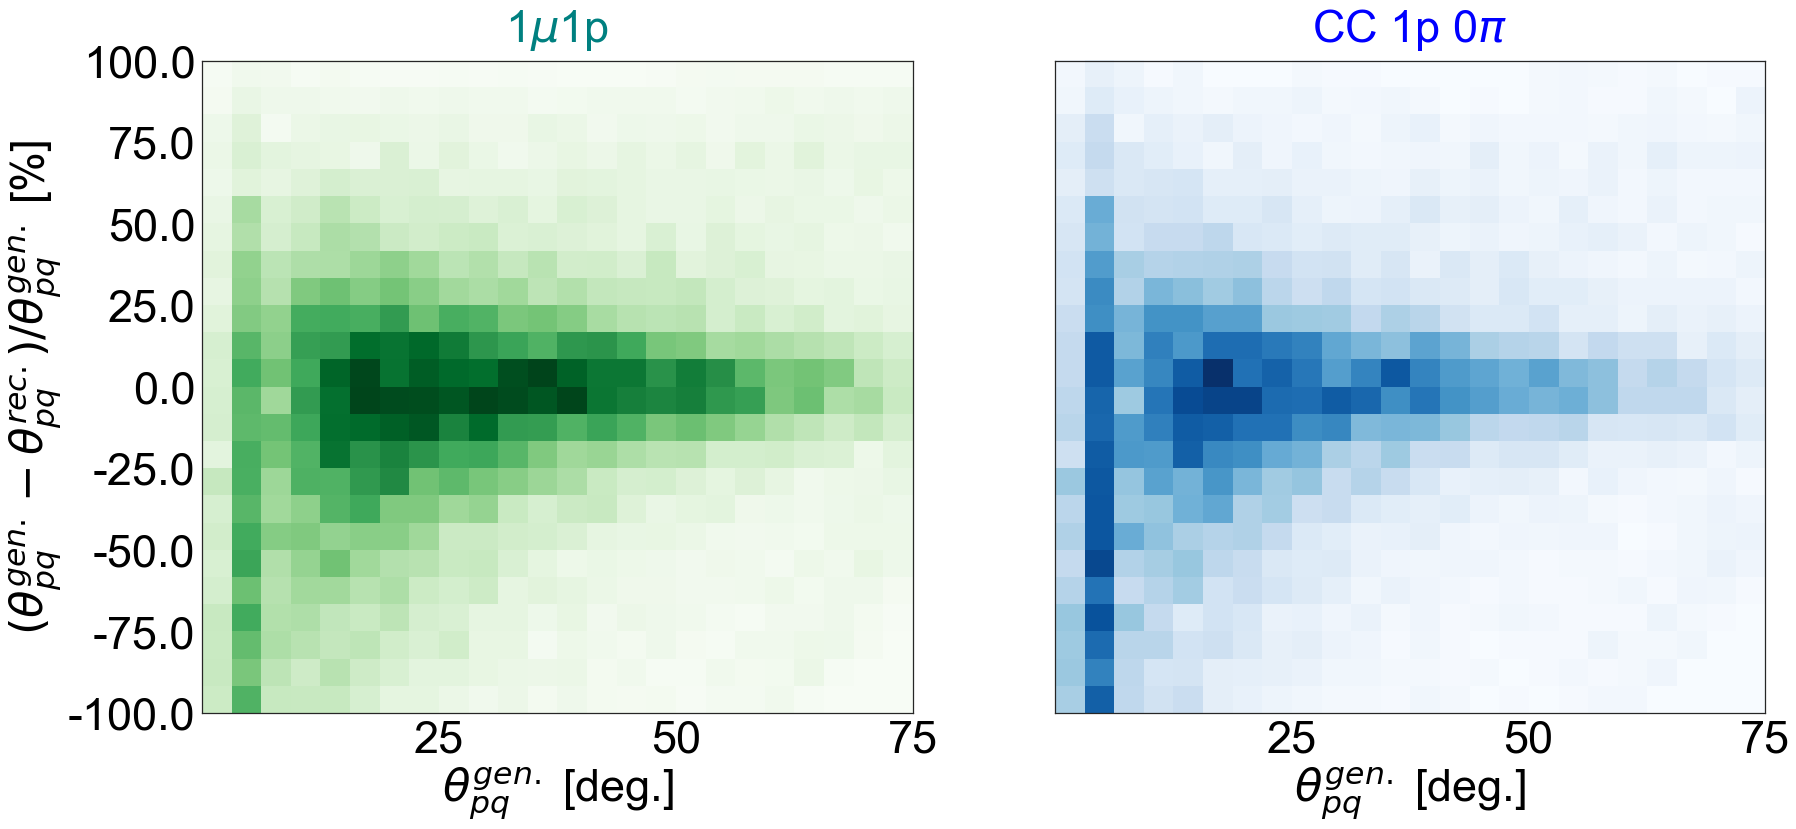

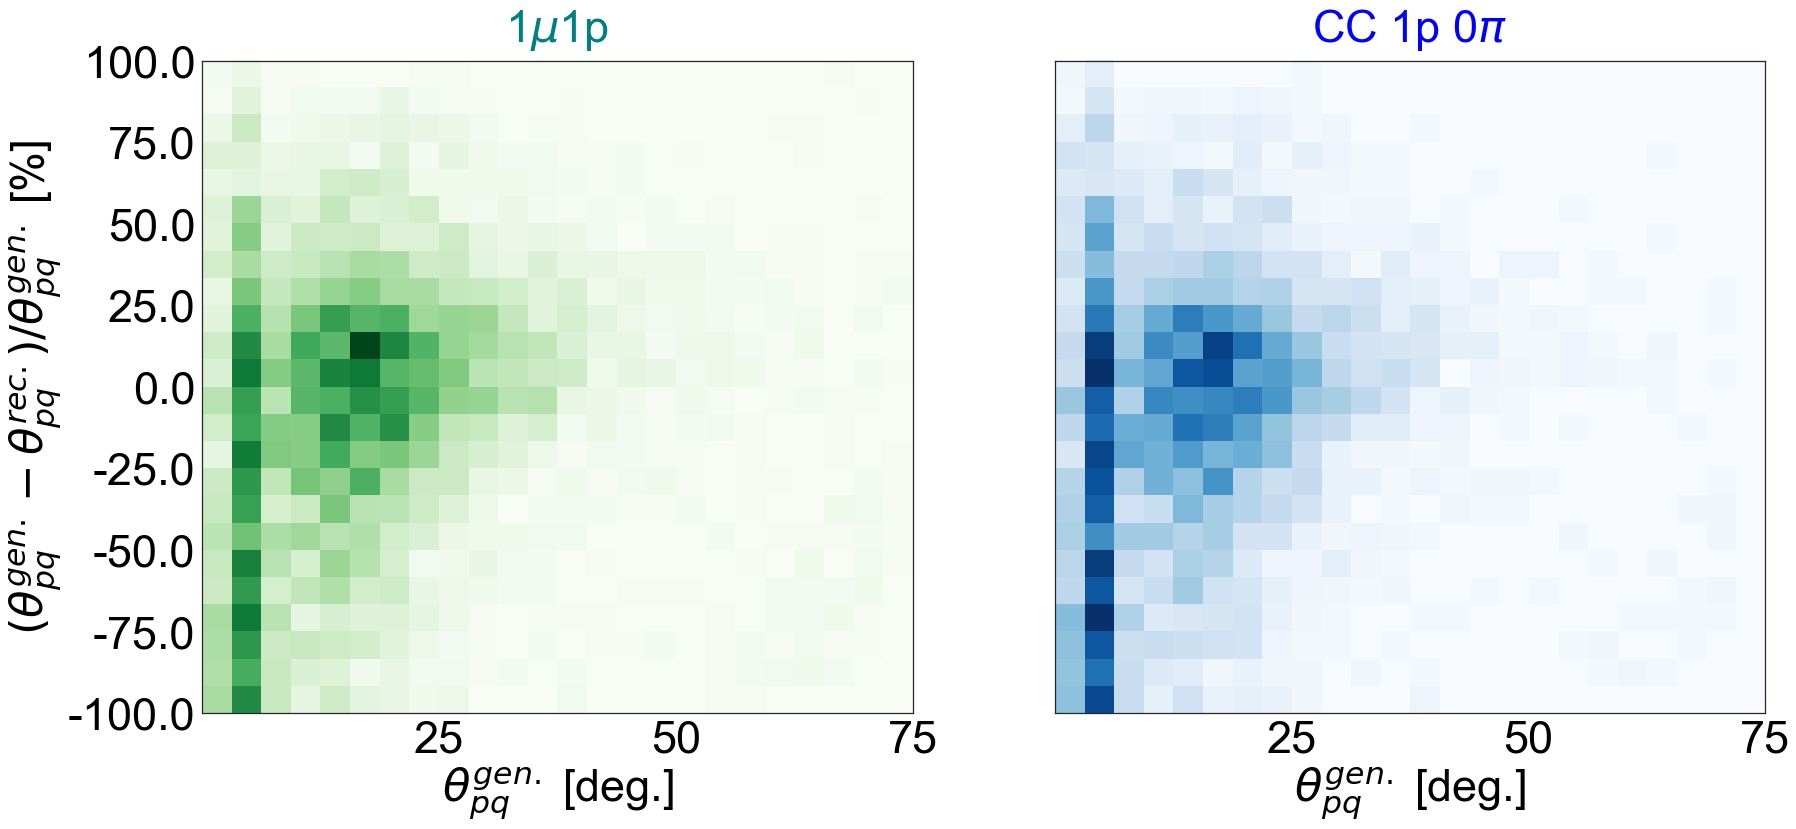

In [6]:
fig = plt.figure(figsize=(28,12))
bins=(np.linspace(0,75,25),np.linspace(-100,100,25))
    
for i,index in enumerate([0,3]):
    pair_type = pair_types[index]
    label = MClabels[index]; cmap = MCcmaps[index]; color = MCcolors[index]
    sample = reducedOverlay['no cut'][pair_type]    
    ax = fig.add_subplot(1,2,i+1)
    ax.set_title(label,fontsize=45,y=1.02,color=color)
    plot_2d_hist(sample['truth_theta_pq'], 
                 100.*(sample['truth_theta_pq']-sample['reco_theta_pq'])/sample['truth_theta_pq'],
                 ax=ax,fontsize=25,ticks_color='black',bins=bins,cmap=cmap,norm='')            
    set_axes(ax,x_label='$\\theta^{gen.}_{pq}$ [deg.]', y_label='$(\\theta^{gen.}_{pq}-\\theta^{rec.}_{pq})/\\theta^{gen.}_{pq}$ [%]' if i==0 else '',ticks_color='black',fontsize=45)
    ax.xaxis.set_ticks([25,50,75])
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f') if i==0 else ticker.NullFormatter())    
fig.savefig(figures_path+'theta_pq/theta_pq_reconstruction.pdf')

fig = plt.figure(figsize=(28,12))
for i,index in enumerate([0,3]):
    pair_type = pair_types[index]
    label = MClabels[index]; cmap = MCcmaps[index]; color = MCcolors[index]
    sample = reducedOverlay['delta phi'][pair_type]    
    ax = fig.add_subplot(1,2,i+1)
    ax.set_title(label,fontsize=45,y=1.02,color=color)
    plot_2d_hist(sample['truth_theta_pq'], 
                 100.*(sample['truth_theta_pq']-sample['reco_theta_pq'])/sample['truth_theta_pq'],
                 ax=ax,fontsize=25,ticks_color='black',bins=bins,cmap=cmap,norm='')            
    set_axes(ax,x_label='$\\theta^{gen.}_{pq}$ [deg.]', y_label='$(\\theta^{gen.}_{pq}-\\theta^{rec.}_{pq})/\\theta^{gen.}_{pq}$ [%]' if i==0 else '',ticks_color='black',fontsize=45)
    ax.xaxis.set_ticks([25,50,75])
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f') if i==0 else ticker.NullFormatter())    
fig.savefig(figures_path+'theta_pq/theta_pq_reconstruction_after_DeltaPhi_cut.pdf')

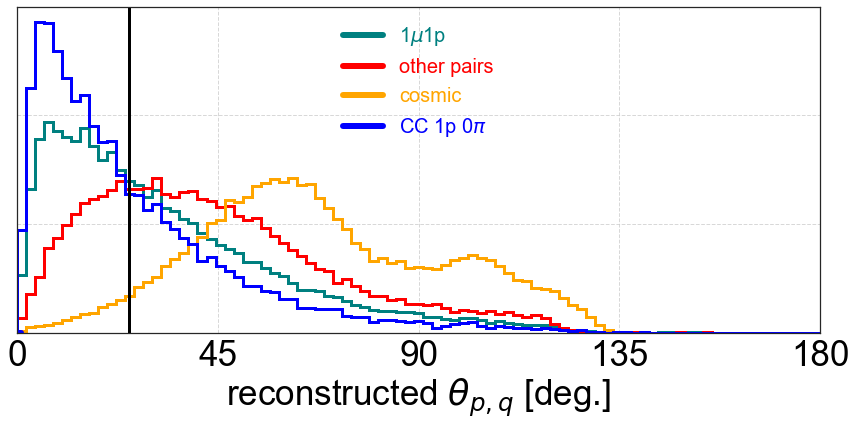

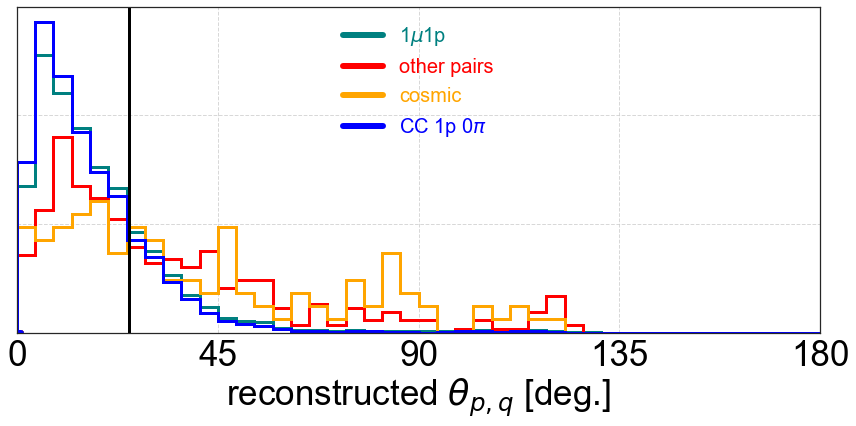

In [9]:
ax=plot_feature_pairs(reduced_samples=reducedOverlay['no cut'],var='reco_theta_pq',x_label='reconstructed $\\theta_{p,q}$ [deg.]'
                              ,bins=np.linspace(0,180,90)
                              ,do_add_legend=True,figsize=(12,6),ticks_color='black',fontsize=35,legend_fontsize=20)
ax.plot([25,25],ax.get_ylim(),'-',color='black',linewidth=3)
plt.savefig(figures_path+'theta_pq/theta_pq.pdf')

# after cut 5
ax=plot_feature_pairs(reduced_samples=reducedOverlay['delta phi'],var='reco_theta_pq',x_label='reconstructed $\\theta_{p,q}$ [deg.]'
                              ,bins=np.linspace(0,180,45)
                              ,do_add_legend=True,figsize=(12,6),ticks_color='black',fontsize=35,legend_fontsize=20)
ax.plot([25,25],ax.get_ylim(),'-',color='black',linewidth=3)
plt.savefig(figures_path+'theta_pq/theta_pq_after_DeltaPhi_cut.pdf')

In [ ]:
ax,leg=plot_cut_samples(reduced_cut_name='delta phi',do_add_legend=True,legend_fontsize=25,legend_loc='lower right'                    
                 ,cut_var ='reco_theta_pq', cut_type= 'max',ticks_color='black'                 
                 ,x_label = 'maximal $\\theta_{p,q}$ [deg.]'
                 ,xmin=0, xmax=90 , Nbins=180,fontsize=40,figsize=(12,7));
ax.plot([25,25],[0,100],'-',color='black')
plt.savefig(figures_path+'theta_pq/theta_pq_cuts.pdf',bbox_extra_artists=(leg,), bbox_inches='tight')

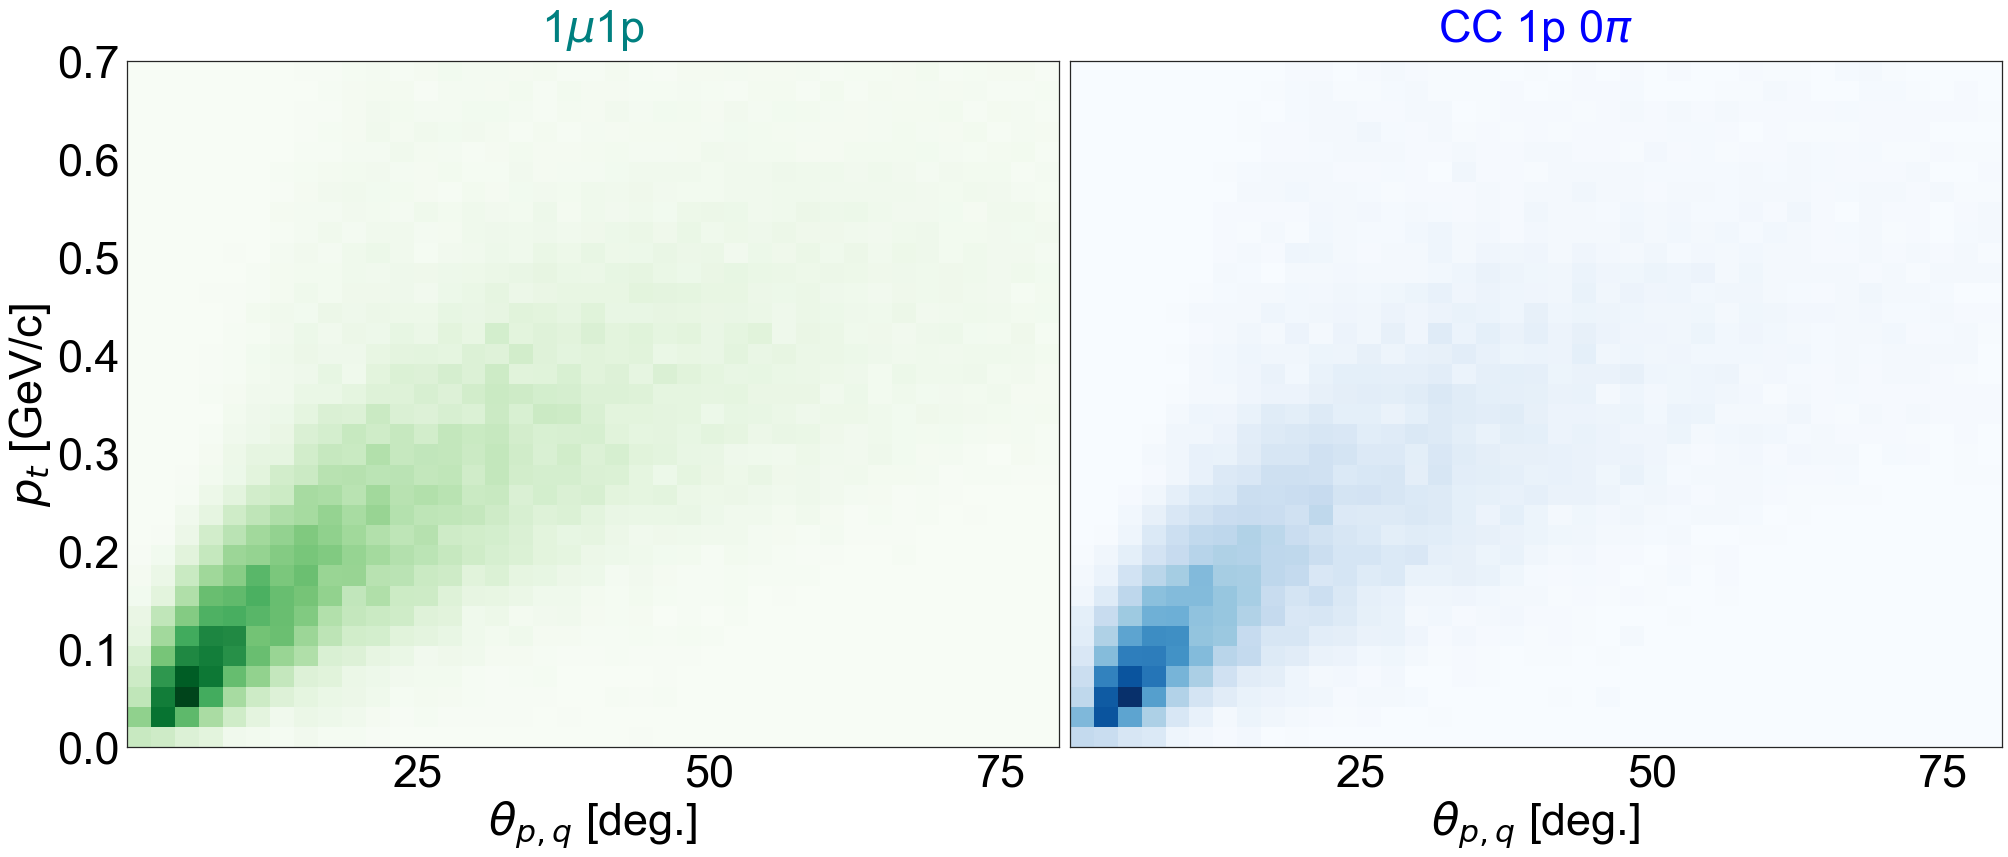

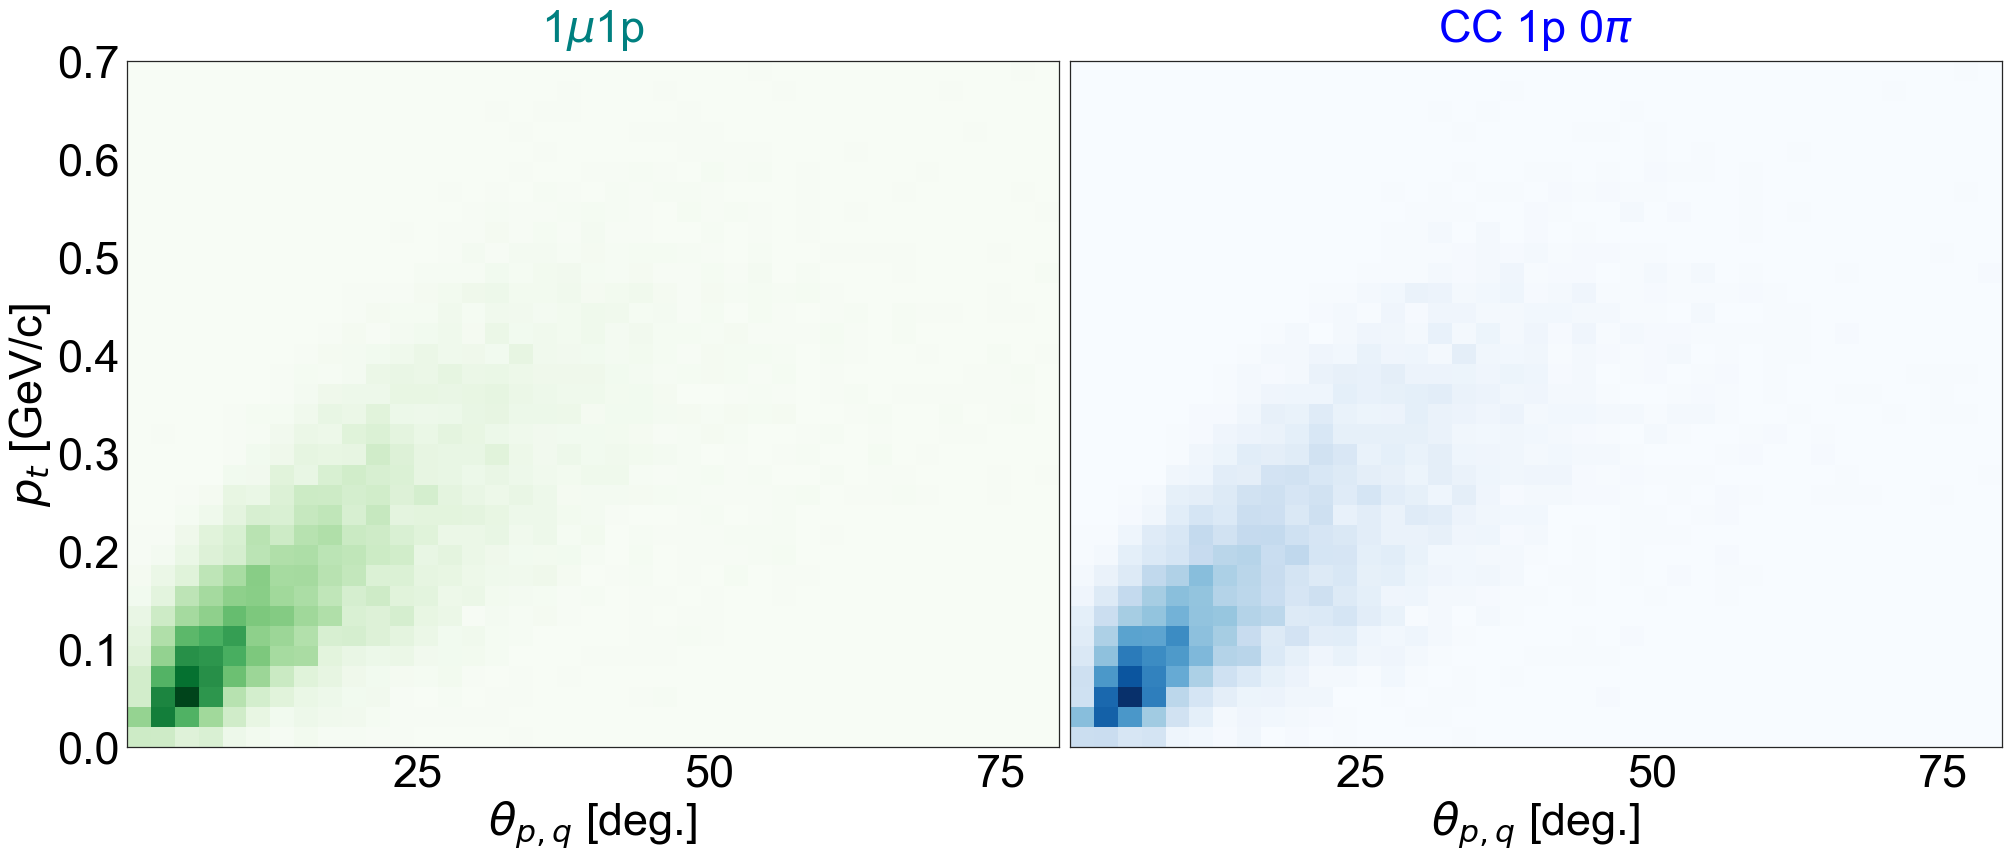

In [42]:
fig = plt.figure(figsize=(28,12))
bins=(np.linspace(0,80,40),np.linspace(0,0.7,35))
x_label,y_label='$\\theta_{p,q}$ [deg.]','$p_{t}$ [GeV/c]'
for i,index in enumerate([0,3]):
    pair_type = pair_types[index]
    label = MClabels[index]; cmap = MCcmaps[index]; color = MCcolors[index]
    sample = reducedOverlay['no cut'][pair_type]    
    ax = fig.add_subplot(1,2,i+1)
    ax.set_title(label,fontsize=45,y=1.02,color=color)
    plot_2d_hist(sample['reco_theta_pq'], 
                 sample['reco_Pt'],
                 ax=ax,fontsize=25,ticks_color='black',bins=bins,cmap=cmap,norm='')            
    set_axes(ax,x_label=x_label, y_label=y_label if i==0 else '',ticks_color='black',fontsize=45)
    ax.xaxis.set_ticks([25,50,75])
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f') if i==0 else ticker.NullFormatter())    
plt.tight_layout()
fig.savefig(figures_path+'theta_pq/theta_pq_vs_Pt.pdf')


fig = plt.figure(figsize=(28,12))
bins=(np.linspace(0,80,40),np.linspace(0,0.7,35))
x_label,y_label='$\\theta_{p,q}$ [deg.]','$p_{t}$ [GeV/c]'
for i,index in enumerate([0,3]):
    pair_type = pair_types[index]
    label = MClabels[index]; cmap = MCcmaps[index]; color = MCcolors[index]
    sample = reducedOverlay['delta phi'][pair_type]    
    ax = fig.add_subplot(1,2,i+1)
    ax.set_title(label,fontsize=45,y=1.02,color=color)
    plot_2d_hist(sample['reco_theta_pq'], 
                 sample['reco_Pt'],
                 ax=ax,fontsize=25,ticks_color='black',bins=bins,cmap=cmap,norm='')            
    set_axes(ax,x_label=x_label, y_label=y_label if i==0 else '',ticks_color='black',fontsize=45)
    ax.xaxis.set_ticks([25,50,75])
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f') if i==0 else ticker.NullFormatter())    
plt.tight_layout()
fig.savefig(figures_path+'theta_pq/theta_pq_vs_Pt_after_DeltaPhi_cut.pdf')